In [15]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators


# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, save_or_load_onehot, build_data, plot_spherical_harmonics_comparison, plot_cartesian_tensor_comparison, extract_and_average)
from utils.utils_model_full_tensor import Network, visualize_layers, train, evaluate


import wandb

from sklearn.metrics import r2_score, mean_squared_error

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor  # Import the converter
import numpy as np

plt.rcParams["mathtext.fontset"] = "cm"
fontsize = 16
textsize = 14
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'sans-serif']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize
plt.rcParams['text.usetex'] = False



bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


## load data
# data_file = '../dataset/openmx_data_20250319_152811.pkl'
data_file = '../dataset/symmetrized_permittivity.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

torch device: cuda:0
data acquired


In [16]:
df.head()

,folder,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_12,Im_20,Im_21,Im_22,avg_re_trace,avg_im_trace,real_symmetrized_permittivity,imag_symmetrized_permittivity,rotation_matrices,species
0,/global/cfs/cdirs/m225/angush/materialProject/...,Li4Se8Y4,"(Atom('Li', [2.8385500000000006, 0.0, 2.88335]...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.481281668892605, -1.3506806366681457e-09,...","[[[-1.0722568410351282e-17, -2.371619162135055...","[3.481281668892605, 3.4813019889159484, 3.4813...",...,"[-6.400276971094875e-19, 1.187453653061564e-12...","[1.3823342267093493e-17, 1.882754707806698e-12...","[-6.400276971094875e-19, 1.187453653061564e-12...","[3.342549740214423e-18, 0.0001803350567406132,...","[3.4405690641171667, 3.44058861685612, 3.44064...","[-7.234861265325764e-18, 0.0001957028760583553...","[[[3.4812758467294405, 0.0, -2.584939414228211...","[[[-1.2523566768095863e-17, 0.0, -4.8148248609...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[Li, Se, Y]"
1,/global/cfs/cdirs/m225/angush/materialProject/...,Mo3S2Se4,"(Atom('Mo', [1.6365999999999998, 0.94489145055...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[5.126763705823415, -0.0036857171285808207, ...","[[[3.2316203633511406e-17, 4.065761255667405e-...","[5.126763705823415, 5.1268254576594545, 5.1270...",...,"[2.6785699480178126e-17, -7.1566796821889846e-...","[-9.092746101489361e-19, 1.2366187483073555e-0...","[2.6785699480178126e-17, -7.1566796821889846e-...","[5.356300432663947e-18, 0.00011878724682517897...","[4.321433518069999, 4.321478600797114, 4.32161...","[1.9282726697651513e-17, 0.0004517163617600133...","[[[5.124538605076387, 6.794333614242494e-18, 5...","[[[2.6245939830145304e-17, -2.5679065925163146...","[[[1.0, 3.969365967485894e-18, 0.0], [0.0, 1.0...","[S, Se, Mo]"
2,/global/cfs/cdirs/m225/angush/materialProject/...,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.7313146368871726, 7.054466462945285e-06, ...","[[[2.9669125906530276e-18, 2.117513176816877e-...","[1.7313146368871726, 1.7313217564659527, 1.731...",...,"[-1.0033425582785427e-17, 8.405343317085762e-1...","[3.969580319788735e-18, 8.535424337320327e-10,...","[-1.0033425582785427e-17, 8.405343317085762e-1...","[-6.4642318455671115e-18, 7.12408590969345e-05...","[1.7313150452437125, 1.7313221648231247, 1.731...","[9.731758164650026e-19, 7.124085259360446e-05,...","[[[1.7313150452437125, -3.529303946892918e-23,...","[[[9.73175816465002e-19, 0.0, 0.0], [0.0, 9.73...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[Nb, Li, S]"
3,/global/cfs/cdirs/m225/angush/materialProject/...,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.2667371759234984, -3.486898178425755e-06,...","[[[-1.7162171221554744e-17, -4.972084285417574...","[3.2667371759234984, 3.266768077328808, 3.2668...",...,"[-5.716867411329558e-18, 1.0499994209043163e-0...","[4.710222018194405e-18, 5.8322763388424595e-09...","[-5.716867411329558e-18, 1.0499994209043163e-0...","[-1.5461680231046413e-17, 0.000264086382651040...","[3.270700626888884, 3.270730008788789, 3.27081...","[-1.1048250663480898e-17, 0.000294768918248031...","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[[[-8.841535879698145e-18, 0.0, -9.62964972193...","[[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0,...","[Se, Cd, Zn]"
4,/global/cfs/cdirs/m225/angush/materialProject/...,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.57865600493003, -2.773634699822434e-08, 0...","[[[-2.370171074423322e-18, -5.455394216331598e...","[3.57865600493003, 3.5786781470220483, 3.57874...",...,"[-2.455824835482616e-18, 3.9216660381713

In [6]:
row = df[df['mp_id']=='mp-545482'].iloc[0]


In [11]:
print(row["crystal_system"])

sym_prec = 1e-2
tolerance = 1e-2

ase_atoms = row.structure  # This is your ASE Atoms object
pymatgen_structure = AseAtomsAdaptor.get_structure(ase_atoms)

# Now use the pymatgen Structure with SpacegroupAnalyzer
sga_primitive = SpacegroupAnalyzer(pymatgen_structure, symprec=sym_prec)
refined_structure = sga_primitive.get_refined_structure()
print(len(sga_primitive.get_symmetry_operations(cartesian=True)))
refined_sga = SpacegroupAnalyzer(refined_structure, symprec=sym_prec)
symmetry_operations = refined_sga.get_symmetry_operations(cartesian=True)
print(len(symmetry_operations))

x = np.ones([3, 3])
mask = np.zeros([3, 3])
for op in symmetry_operations:
    R = op.rotation_matrix 
    print(R)
    mask += R @ x @ R.T
mask /= len(symmetry_operations)
print(mask)
from pymatgen.io.vasp import Poscar
poscar = Poscar(pymatgen_structure)
poscar.write_file("POSCAR")

monoclinic
4
4
[[ 1.00000000e+00  0.00000000e+00 -6.53032277e-18]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.00000000e+00  0.00000000e+00  6.53032277e-18]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
[[-1.00000000e+00  0.00000000e+00  6.53032277e-18]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00 -6.53032277e-18]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[1. 0. 1.]
 [0. 1. 0.]
 [1. 0. 1.]]


/home/angush/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


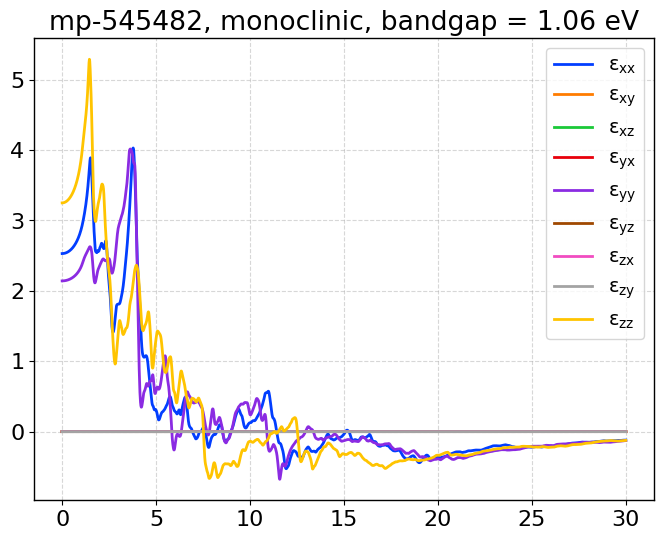

In [14]:
spectra = row["real_symmetrized_permittivity"]
colors = sns.color_palette("bright", 9)  # Colorblind-friendly, distinct colors
import spglib

xyz_list = ["x", "y", "z"]
omega = df.iloc[0].omega  # Assuming omega is the same for all entries

plt.figure(figsize=(8, 6),dpi=100)

for i in range(3):
    for j in range(3):
        color = colors[(i * 3 + j) % len(colors)]  # Cycle through colors
        plt.plot(omega, spectra[:, i, j], 
                    label=f"$\epsilon_{{{xyz_list[i]}{xyz_list[j]}}}$",  # Both indices as subscripts
                    color=color, linewidth=2)
atoms = row.structure
cell = (atoms.cell, atoms.get_scaled_positions(), atoms.numbers)
spacegroup = spglib.get_spacegroup(cell, symprec=sym_prec)  # Adjust symprec if needed
spacegroup_number = spglib.get_symmetry_dataset(cell, symprec=sym_prec)['number']

plt.title(f"{row.mp_id}, {row.crystal_system}, bandgap = {row.bandgap:.2f} eV")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)  # Light dashed grid for readability
plt.show()